In [1]:
import pandas as pd

dataset_path = "/home/kosenko/deepspeed/DeepSpeedExamples/applications/DeepSpeed-Chat/training/step1_supervised_finetuning/models/xglm-4.5B_ru_v5/IlyaGusev_llama_7b_ru_turbo_alpaca_loravs.csv"

dataset = pd.read_csv(dataset_path)

In [5]:
dataset.columns

Index(['baseline_model', 'finetuned_model', 'finetuned_prompt',
       'baseline_prompt', 'original_answer', 'baseline_model_output',
       'finetuned_model_output'],
      dtype='object')

In [17]:
model_result = dataset.iloc[0]["baseline_model_output"]
search_str = "Выход:"
model_result = model_result[model_result.index(search_str) + len(search_str) :].strip()
model_result

'История развития компьютерной техники начинается в 1940-х годах, когда первые электронные компьютеры были созданы. В 1950-х годах началось массовое производство электронных компьютеров, а в 1960-х годах появились первые персональные компьютеры.\n\nВ 1970-х годах началась эра микропроцессоров, которые позволили создавать более быстрые и мощные компьютеры. В 1980-х годах появились первые персональные компьютеры с графическим интерфейсом и операционными системами.\n\nВ 1990-х годах компьютерная техника стала более доступной для широкой аудитории. Это было связано с появлением новых технологий, таких как Интернет и World Wide Web.\n\nВ 2000-х годах компьютерная техника продолжала развиваться, появлялись новые технологии, такие как смартфоны, планшетные компьютеры и виртуальная реальность.\n\nВ настоящее время компьютерная техника продолжает развиваться и вносить значительный вклад в наше общество. Она может использоваться для создания различных программ, игр, но является большим осредован

In [16]:
model_result = (
    dataset.iloc[0]["finetuned_model_output"].replace("<|endoftext|>", "").strip()
)
model_result

'Компьютерная техника развивалась с течением времени, от первых механических вычислительных устройств до современных суперкомпьютеров. Первыми компьютерами были механические устройства, такие как аналитическая машина Чарльза Бэббиджа и Аналитической машины Алана Тьюринга, которые использовали шестерни и рычаги для выполнения математических операций. Эти ранние компьютеры были ограничены в своей способности выполнять простые вычисления и не могли выполнять более сложные операции. В конце 19-го века Томас Эдисон изобрел первый электрический компьютер, который можно было использовать для решения проблем. Это был крошечный механический компьютер, называемый Analytical Engine, который мог решать уравнения и выполнять арифметические операции. Тем не менее, этот тип компьютера был слишком медленным для реальных вычислений и не мог сравниться с современными суперкомпьютерами. С тех пор прогресс в области вычислительной техники позволил создать множество различных типов компьютеров, включая эле

In [13]:
finetuned_prompt = dataset.iloc[0]["finetuned_prompt"]
finetuned_prompt = (
    finetuned_prompt.replace("Human:", "").replace("Assistant:", "").strip()
)
finetuned_prompt

'Напишите краткое эссе на тему "История развития компьютерной техники".'

In [45]:
import random

eval_dataset = {
    "initial_instruction": [],
    "model_1": [],
    "model_2": [],
    "user_score": [],
    "model_1_used": [],
    "model_2_used": [],
}

models_list = ["IlyaGusev/llama_7b_ru_turbo_alpaca_lora", "xglm_4.5B_ru_v5"]

for i in range(100):
    finetuned_prompt = dataset.iloc[i]["finetuned_prompt"]
    finetuned_prompt = (
        finetuned_prompt.replace("Human:", "").replace("Assistant:", "").strip()
    )
    eval_dataset["initial_instruction"].append(finetuned_prompt)

    # бейзлайн
    model_result = dataset.iloc[i]["baseline_model_output"]
    search_str = "Выход:"
    model_result = model_result[
        model_result.index(search_str) + len(search_str) :
    ].strip()

    # зафайтюненая версия
    model_result_2 = (
        dataset.iloc[i]["finetuned_model_output"].replace("<|endoftext|>", "").strip()
    )

    model = random.choice(models_list)
    if model == models_list[0]:
        eval_dataset["model_1"].append(model_result)
        eval_dataset["model_2"].append(model_result_2)
        eval_dataset["model_1_used"].append(models_list[0])
        eval_dataset["model_2_used"].append(models_list[1])
    else:
        eval_dataset["model_1"].append(model_result_2)
        eval_dataset["model_2"].append(model_result)
        eval_dataset["model_1_used"].append(models_list[1])
        eval_dataset["model_2_used"].append(models_list[0])

    eval_dataset["user_score"].append(" ")

pd.DataFrame(data=eval_dataset).to_csv(
    "./human_eval_dataset/human_eval_1.csv", index=False
)

### compute scores

In [18]:
import pandas as pd

excel_path = "./human_eval_dataset/human_eval_1.xlsx"
dataset = pd.ExcelFile(excel_path, engine="openpyxl")

In [16]:
dataset.sheet_names

['human_eval_1', 'Sheet1', 'Sheet2', 'Sheet3', 'Sheet4']

In [84]:
user_labels = []
total_labels = []

for sheet in dataset.sheet_names:
    print(sheet)
    human = pd.read_excel(excel_path, sheet_name=sheet)
    labels = human["model_1_used"].unique().tolist()
    labels = {lab: [] for lab in labels}

    if sheet == "Sheet2":
        human.loc[41, "user_score"] = 1
    elif sheet == "Sheet3":
        human.loc[88, "user_score"] = 2
    user_labels.append(human["user_score"].tolist())

    for i in range(len(human)):
        # print(i)
        user_score = int(human.iloc[i]["user_score"])
        model_name = human.iloc[i][f"model_{user_score}_used"]
        labels[model_name].append(1)

    for lab in labels.keys():
        print(f"{lab} - {sum(labels[lab])}")

    total_labels.append(labels)

human_eval_1
IlyaGusev/llama_7b_ru_turbo_alpaca_lora - 62
xglm_4.5B_ru_v5 - 38
Sheet1
IlyaGusev/llama_7b_ru_turbo_alpaca_lora - 55
xglm_4.5B_ru_v5 - 45
Sheet2
IlyaGusev/llama_7b_ru_turbo_alpaca_lora - 60
xglm_4.5B_ru_v5 - 40
Sheet3
IlyaGusev/llama_7b_ru_turbo_alpaca_lora - 48
xglm_4.5B_ru_v5 - 52
Sheet4
IlyaGusev/llama_7b_ru_turbo_alpaca_lora - 57
xglm_4.5B_ru_v5 - 43


In [89]:
win_per_human = [sum(item["xglm_4.5B_ru_v5"]) / 100 for item in total_labels]
win_per_human, sum(win_per_human) / len(win_per_human)

([0.38, 0.45, 0.4, 0.52, 0.43], 0.43600000000000005)

<Axes: >

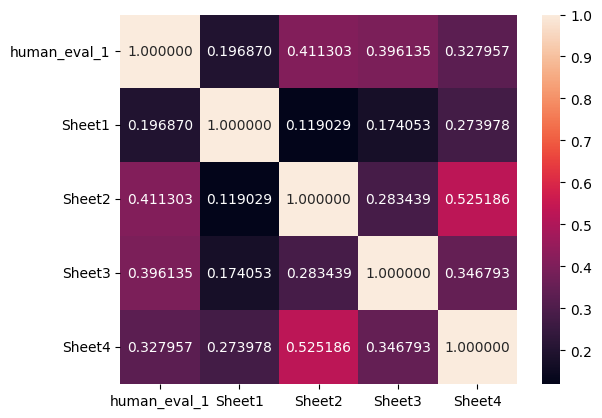

In [83]:
from sklearn.metrics import cohen_kappa_score
import seaborn as sns

matrix_agreement = []

for label1, user_name in zip(user_labels, dataset.sheet_names):
    row = []
    for label2, user_name in zip(user_labels, dataset.sheet_names):
        cohen_score = cohen_kappa_score(label1, label2)
        row.append(cohen_score)
    matrix_agreement.append(row)

sns.heatmap(
    matrix_agreement,
    xticklabels=dataset.sheet_names,
    yticklabels=dataset.sheet_names,
    fmt="f",
    annot=True,
)